# <center> **Regression problem: cab ride time**

## Description

<tiny> *The project idea and data were taken from a <a href="https://www.kaggle.com/c/nyc-taxi-trip-duration">Kaggle project (2017)</a>. The project was conducted within an advanced training course "Data Science" by SkillFactory.*</tiny>

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
This is a study project that solves a real machine learning problem aimed at automating business processes. The goal is to build a model that will predict the total duration of a cab ride in New York City. 

Imagine you order a cab from one point in New York City to another, and the end point doesn't necessarily have to be within the city. How much will you have to pay for it? It is known that the cost of a cab in the United States is based on a flat rate + fare, the amount of which depends on time and distance. Fares vary from city to city.

In turn, the time of the trip depends on many factors such as where to and where from you are going, at what time of the day you make your trip, weather conditions and so on. 

So, if there was an algorithm capable of determining the duration of the trip, the cost of the trip could be predicted in the most trivial way, for example, simply by multiplying the cost by a given fare. 
Cab services store huge amounts of information about trips, including data such as the endpoint, the starting point of the route, the date of the trip, and the duration of the trip. This data can be used to predict the duration of a trip automatically using artificial intelligence.

**Business Task:** Determine the features and use them to predict the duration of the cab trip.

**Technical task:** build a machine learning model that will predict a continuous target variable - cab ride time - based on the proposed customer characteristics. That is, solve the regression problem.

**Main goals of the project:**
1. Generate a data set based on several sources of information.
2. Design new features using Feature Engineering and identify the most significant ones when building the model.
3. Examine the data and identify patterns.
4. Build several models and select the best one for a suitable metric.
5. Design a process for predicting travel time for new data.

Skills practiced in this project are: working with multiple data sources, generating features, exploratory analysis and data visualization, feature selection and, of course, building machine learning models.


## Data extraction

Let's start our research by getting to know the provided data. We will also load additional data sources and expand our initial dataset. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [3]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head(2)

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


There are data on almost 1.5 million trips and 11 features that describe each trip. 

We divide the attributes into several groups:

**Trip and cab company data:**
* id - unique identifier of the trip
* vendor_id - the unique identifier of the supplier (taxi company) connected with the trip record

**temporal characteristics:**
* pickup_datetime - date and time when the trip counter was activated
* dropoff_datetime - date and time when the counter was deactivated

**Geographic characteristics:**
* pickup_longitude - the longitude at which the counter was activated
* pickup_latitude - the latitude at which the counter was activated
* dropoff_longitude - the longitude at which the counter was deactivated
* dropoff_latitude - the latitude at which the counter was deactivated

**Other attributes:**
* passenger_count - number of passengers in the vehicle (value entered by the driver)
* store_and_fwd_flag - flag that indicates whether the trip record was stored in the vehicle memory before being sent to the vendor. Y - store and forward, N - do not store and forward the trip.

**Target attribute:**
* trip_duration - duration of the trip in seconds


In [4]:
#  change date features to datetime format
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
min_pickup = taxi_data['pickup_datetime'].min()
max_pickup  = taxi_data['pickup_datetime'].max()
print(f'Data are collected with the time period: from {min_pickup:%Y-%m-%d} to {max_pickup:%Y-%m-%d}' )

Data are collected with the time period: from 2016-01-01 to 2016-06-30


In [5]:
# Check n/a
print(f'Number of missing values in the data is: {taxi_data.isna().sum().sum()}')


Number of missing values in the data is: 0


### Feature Engineering

In [6]:
from my_functions import *
# add columns pickup_date, pickup_hour, pickup_day_of_week
taxi_data = add_datetime_features(taxi_data) # 
# add a column that indicates whether the cab ride took place on a holiday or not
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
taxi_data = add_holiday_features(holiday_data, taxi_data)
# add information on total distance, travel time and number of steps calculated based on OSRM API
osrm_data = pd.read_csv('data/osrm_data_train.csv')
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [7]:
coordinates = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
# add haversine distance and angle of the direction to the taxi_data 
taxi_data = add_geographical_features(taxi_data, coordinates)

In [8]:
coordinates_pickup = ['pickup_latitude', 'pickup_longitude']
coordinates_dropoff = ['dropoff_latitude', 'dropoff_longitude']
# add a feature cluster based on the KMeans clustering of pick-up and drop-off locations
taxi_data = add_cluster_features(taxi_data, coordinates_pickup, coordinates_dropoff)
# add weather information 
weather_data = pd.read_csv('data/weather_data.csv')
taxi_data = add_weather_features(taxi_data, weather_data)
  

### Data cleaning

We are done with feature engineering. The next step, is to clean data from missing values and outliers. 

In [9]:
taxi_data.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,date,hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,2016-03-14,17.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,2016-06-12,0.0


In [10]:
# Check for n/a
taxi_data.isna().sum()[taxi_data.isna().sum() > 0] 

total_distance           1
total_travel_time        1
number_of_steps          1
temperature          12032
visibility           12032
wind speed           12032
precip               12032
events               12032
date                 12032
hour                 12032
dtype: int64

As it is seen, there are missing values in several variables. We replace those n/a as follows: 

- **temperature, visibility, wind speed, precip** with respective median value depending on the trip start date using function *fill_null_weather_data*
- missing values in **events** are replaced with 'None', i.e. no weather events
- **total_distance, total_travel_time, number_of_steps** with respective median value

In [11]:
def fill_null_weather_data(taxi_data):
    for col in ['temperature', 'visibility', 'wind speed', 'precip' ]: 
        taxi_data[col] = taxi_data[col].fillna(
            taxi_data.groupby('pickup_date')[col].transform('median'))
    return taxi_data

taxi_data = fill_null_weather_data(taxi_data)

In [12]:
osrm_vars = ['total_distance', 'total_travel_time', 'number_of_steps' ]
taxi_data[osrm_vars] = taxi_data[osrm_vars].fillna(taxi_data[osrm_vars].median())

In [13]:
col = 'events'
taxi_data[col].fillna('None', inplace= True)


In [14]:
taxi_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06
pickup_hour,1458644.0,13.606484,6.399693,0.000000,9.000000,14.000000,19.000000,2.300000e+01
pickup_day_of_week,1458644.0,3.050375,1.954039,0.000000,1.000000,3.000000,5.000000,6.000000e+00
pickup_holiday,1458644.0,0.035048,0.183900,0.000000,0.000000,0.000000,0.000000,1.000000e+00


We observe extreme values in the target variables. Let`s consider value an outlier if the duration of the trip is more than 24 hours. For too short trips, that is, e.g. a trip that was canceled immediately after the start or with implausibly high speed, we calculate the average speed as follows:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$ 

''

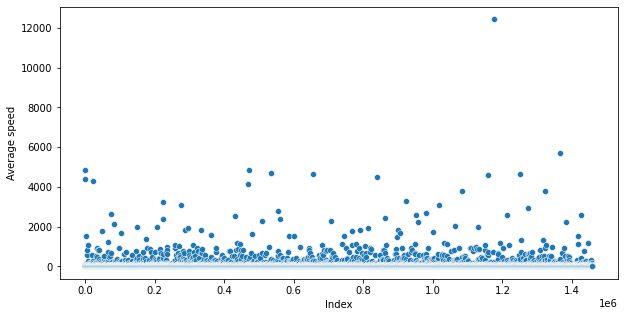

In [15]:
# scatter plot of average speed
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed')
;

Let`s consider average speed greater than 300km/h an outlier.

In [16]:
taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
print("There are", taxi_data[taxi_data['avg_speed']>300].shape[0], "with average speed greater than 300km/h.")
print("There are", taxi_data.loc[taxi_data['trip_duration'] > 24*60*60].shape[0], "trips that lasted longer than 24 hours.")

There are 407 with average speed greater than 300km/h.
There are 4 trips that lasted longer than 24 hours.


In [17]:
# Drop the outliers
row_to_drop = taxi_data.loc[taxi_data['trip_duration'] > 24*60*60].index
taxi_data.drop(index=row_to_drop, axis = 0, inplace = True)
row_to_drop = taxi_data.loc[taxi_data['avg_speed'] > 300].index
taxi_data.drop(index=row_to_drop, axis = 0, inplace = True)

In [18]:
taxi_data.shape

(1458233, 29)

## EDA

### Descriptives

In this part of our project, we will:
* Explore the extended data set;
* Try to find patterns that allow to formulate preliminary hypotheses regarding which factors
are decisive in determining the duration of the trip;
* Supplement the analysis with visualizations illustrating.

In [19]:
# Descriptives of qualitatives features
taxi_data.describe(include='object')

,id,store_and_fwd_flag,events
count,1458233,1458233,1458233
unique,1458233,2,4
top,id2875421,N,None
freq,1,1450192,1386830


In [20]:
# Descriptives of countinuous features
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,pickup_day_of_week,pickup_holiday,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,hour,avg_speed
count,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,...,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.458233e+06,1.446207e+06,1.458233e+06
mean,1.534975e+00,1.664613e+00,-7.397350e+01,4.075093e+01,-7.397343e+01,4.075181e+01,9.530741e+02,1.360660e+01,3.050360e+00,3.504310e-02,...,7.546921e+00,3.439292e+00,-1.567448e+01,3.761448e+00,1.109192e+01,1.474652e+01,8.939616e+00,6.761574e-02,1.364238e+01,1.923332e+01
std,4.987754e-01,1.314303e+00,7.085886e-02,3.119600e-02,7.037380e-02,3.561632e-02,3.171727e+03,6.399694e+00,1.954017e+00,1.838888e-01,...,4.432420e+00,4.064528e+00,1.044903e+02,3.662305e+00,9.121469e+00,3.053311e+00,7.210713e+00,4.616256e-01,6.378470e+00,1.069963e+01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+00,0.000000e+00,-1.799927e+02,0.000000e+00,-1.830000e+01,4.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073589e+01,3.970000e+02,9.000000e+00,1.000000e+00,0.000000e+00,...,5.000000e+00,1.232410e+00,-1.252843e+02,0.000000e+00,3.900000e+00,1.610000e+01,5.600000e+00,0.000000e+00,9.000000e+00,1.240791e+01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397976e+01,4.075453e+01,6.630000e+02,1.400000e+01,3.000000e+00,0.000000e+00,...,6.000000e+00,2.094297e+00,8.201375e+00,4.000000e+00,1.110000e+01,1.610000e+01,9.300000e+00,0.000000e+00,1.400000e+01,1.710614e+01
75%,2.000000e+00,2.000000e+00,-7.396734e+01,4.076836e+01,-7.396302e+01,4.076981e+01,1.075000e+03,1.900000e+01,5.000000e+00,0.000000e+00,...,9.000000e+00,3.876099e+00,5.339397e+01,9.000000e+00,1.830000e+01,1.610000e+01,1.300000e+01,0.000000e+00,1.900000e+01,2.349589e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,8.639200e+04,2.300000e+01,6.000000e+00,1.000000e+00,...,4.600000e+01,5.748754e+02,1.800000e+02,9.000000e+00,3.220000e+01,1.610000e+01,1.370000e+02,1.190000e+01,2.300000e+01,2.987150e+02


We begin with the target. Looking ahead, let's say that the main evaluating metric will be RMSLE - Root Mean Squared Log Error, which is calculated based on the target variable in a logarithmic scale. In this case, it is advisable to take the logarithm of the target:
$$trip\_duration\_log = ln(trip\_duration+1),$$


In [21]:
# Log transformation of the target variable
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

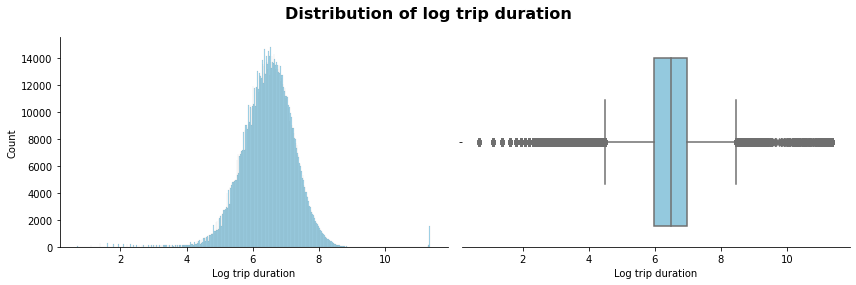

In [22]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

sns.histplot(data = taxi_data, x = 'trip_duration_log', ax = ax[0], color = 'skyblue')
sns.boxplot(data = taxi_data, x = 'trip_duration_log', ax = ax[1], color = 'skyblue')
ax[0].set_xlabel('Log trip duration')
ax[1].set_xlabel('Log trip duration')
plt.suptitle('Distribution of log trip duration', fontsize=16,fontweight ="bold")
fig.tight_layout()
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
plt.show()

In [23]:
# Perfom a notmality check
import scipy
scipy.stats.normaltest(taxi_data['trip_duration_log'])
# Th distribution is not normal at 5% sign. level as p-value < 0.05

NormaltestResult(statistic=138350.16605405, pvalue=0.0)

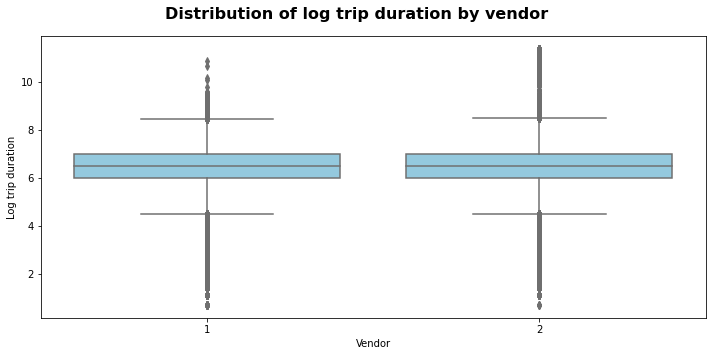

In [24]:
# Compare the trip duration by vendor
fig, ax = plt.subplots(1,1, figsize = (10,5))

sns.boxplot(data = taxi_data, x ='vendor_id',y =  'trip_duration_log',color = 'skyblue')
plt.ylabel('Log trip duration')
plt.xlabel('Vendor')
plt.suptitle('Distribution of log trip duration by vendor', fontsize=16,fontweight ="bold")
fig.tight_layout()
plt.show()

Visually, we do not observe much difference between the vendor. 

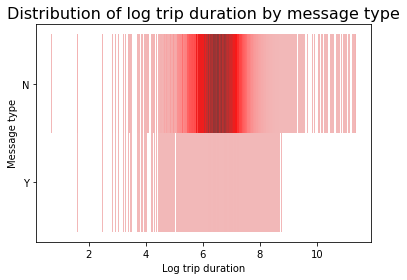

In [25]:
# Compare the message type
plt.title('Distribution of log trip duration by message type', fontsize=16)
plt.xlabel('Log trip duration')
plt.ylabel('Message type')
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    y='store_and_fwd_flag',
    bins=1000,
    color='red'
);

We observe that the trips about which the messages were not sent and stored have wider range of log trip duration and concentrated around 6, whole those with messages sent are distributed more or less equally.

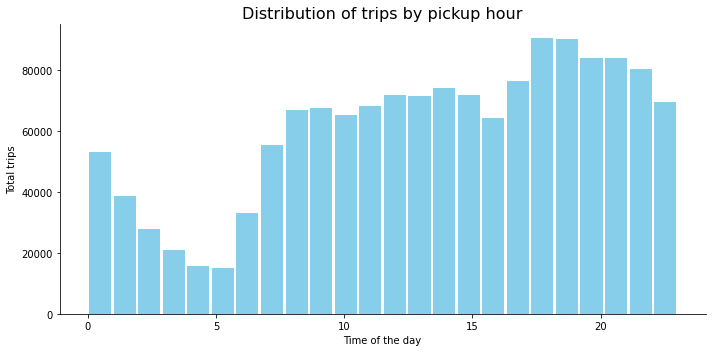

In [26]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
plt.title('Distribution of trips by pickup hour', fontsize=16)
plt.xlabel('Time of the day')
plt.ylabel('Total trips')
taxi_data['pickup_hour'].hist(bins = 24, rwidth = 0.9, color = 'skyblue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
plt.tight_layout()

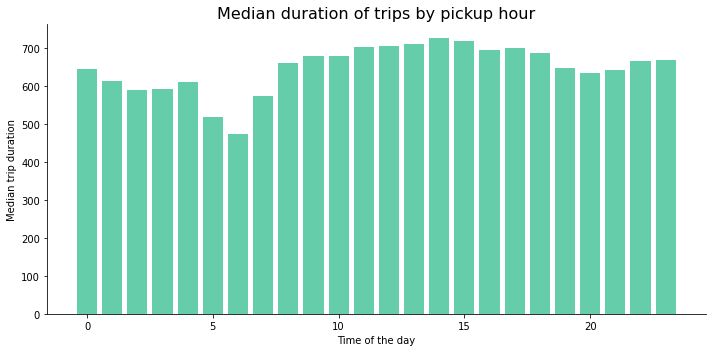

In [27]:
median_trip_duration = taxi_data.groupby('pickup_hour')['trip_duration'].median()

fig, ax = plt.subplots(1,1, figsize = (10,5))
plt.title('Median duration of trips by pickup hour', fontsize=16)
plt.xlabel('Time of the day')
plt.ylabel('Median trip duration')
plt.bar( median_trip_duration.index, median_trip_duration, color = 'mediumaquamarine')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
plt.tight_layout()


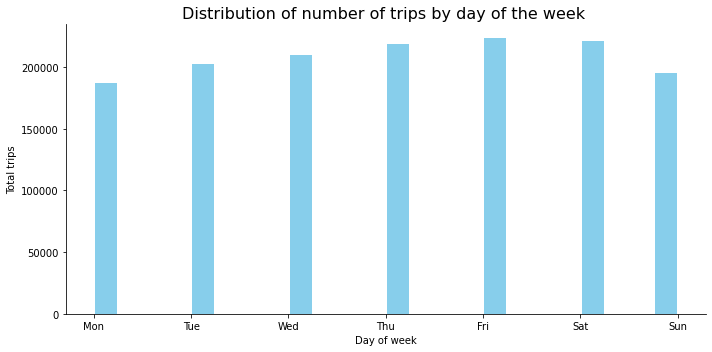

In [28]:
# Distribution of number of trips by day of the week 
fig, ax = plt.subplots(1,1, figsize = (10,5))
plt.title('Distribution of number of trips by day of the week ', fontsize=16)
plt.xlabel('Day of week')
plt.ylabel('Total trips')
taxi_data['pickup_day_of_week'].hist(bins = 24, rwidth = 0.9, color = 'skyblue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x = list(range(7))
plt.xticks( x,
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.grid(False)
plt.tight_layout()

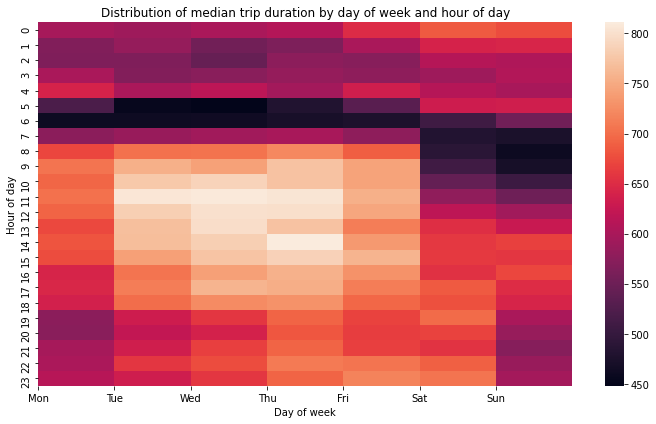

In [29]:
median_trip_duration = pd.pivot_table(data = taxi_data, 
               index= 'pickup_hour', 
               columns='pickup_day_of_week', 
               values='trip_duration', 
               aggfunc='median')
fig, ax = plt.subplots(1,1, figsize = (10,6))
sns.heatmap(median_trip_duration)
plt.title('Distribution of median trip duration by day of week and hour of day')
plt.xlabel('Day of week')
plt.ylabel('Hour of day')
plt.xticks( median_trip_duration.columns,
          ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()

The most popular day of the week to have a cab ride Fri with Thu and Sat right after it. The largest number of trips take place between 6pm and 7pm, very few rides are observed at night. The longest trips in terms of median duration happen at 4pm. Though once we look at the distribution by hour and day of the week, we see that the longest trips take place on Tue, Wed, Thu at 11am (median trip duration).

Text(0.5, 1.0, 'Dropoff location')

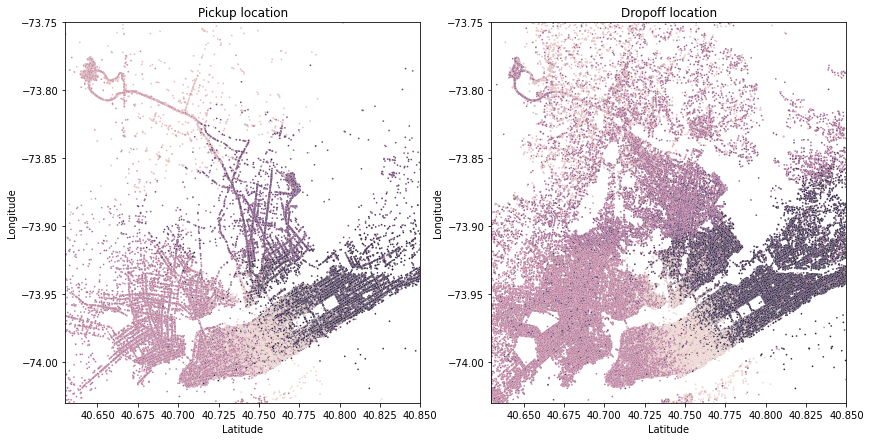

In [30]:
# Scatter plot of pickup and dropoff locations
import seaborn as sns
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(1, 2, figsize = (14, 7))
sns.scatterplot(data= taxi_data, 
                x = 'pickup_latitude',  
                y  = 'pickup_longitude',  
                hue='geo_cluster', 
                s = 3, 
                ax= ax[0], 
                legend = None)  
ax[0].set_xlabel('Latitude')
ax[0].set_xlim(city_lat_border)
ax[0].set_ylabel('Longitude')
ax[0].set_ylim(city_long_border)
ax[0].set_title('Pickup location')

sns.scatterplot(data= taxi_data, 
                x = 'dropoff_latitude', 
                y  = 'dropoff_longitude', 
                hue='geo_cluster', 
                s = 3, 
                ax= ax[1], 
                legend = None)
ax[1].set_xlabel('Latitude')
ax[1].set_xlim(city_lat_border)
ax[1].set_ylabel('Longitude')
ax[1].set_ylim(city_long_border)
ax[1].set_title('Dropoff location')

#plt.tight_layout()

## 4. Feature selection and transformation

Before moving on to building the model, there are a few more steps to take.
* Encode categorical features;
* Select the features that we will use to train the model;
* Scale and transform some features in order to improve the convergence of models based on numerical methods.


In [31]:
drop_columns = ['date', 'hour', 'avg_speed']
taxi_data = taxi_data.drop(drop_columns, axis=1)

print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


In [32]:
# Copy the dataset
train_data = taxi_data.copy()
train_data.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493


In [33]:
# Drop some useless variables that do not contribute any information or create data leak
drop_columns = ['id', 'dropoff_datetime','pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


In [34]:
# Encode vendor 1 as 0, vendor 2 as 1.
train_data['vendor_id'].replace(1 , 0, inplace = True) 
train_data['vendor_id'].replace(2 , 1, inplace = True) 
print("The share of trip provided by vendor 2 is", round(train_data.vendor_id.mean(), 2)) 

The share of trip provided by vendor 2 is 0.53


We observe nearly equal distribution of vendors.

In [35]:
train_data.loc[train_data.store_and_fwd_flag == 'Y', 'store_and_fwd_flag'] = 1
train_data.loc[train_data.store_and_fwd_flag == 'N', 'store_and_fwd_flag'] = 0

round(train_data.store_and_fwd_flag.mean(), 3)


0.006

In [36]:
# One hot encoding of categorical variables
one_hot = sklearn.preprocessing.OneHotEncoder(drop='first')
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
one_hot_array = one_hot.fit_transform(train_data[columns_to_change]).toarray()
column_name = one_hot.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(one_hot_array, columns= column_name)

data_onehot.shape

print('Shape of data: {}'.format(train_data.shape))
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1)
print('Shape of data with encoded cat. features: {}'.format(train_data.shape))

Shape of data: (1458233, 23)
Shape of data with encoded cat. features: (1458233, 38)


In [37]:
# Create X and y 
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

# devide data into train and validation sets
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

In [38]:
# perform feature selection, resulting in 25 best features
from sklearn.feature_selection import SelectKBest, f_regression

fs = SelectKBest(f_regression, k=25)
fs.fit(X_train, y_train_log)

fs.get_feature_names_out()

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

In [39]:
# Keep only selected variables
selected_vars = fs.get_feature_names_out().tolist()
selected_vars
X_train = X_train[selected_vars] 
X_valid = X_valid[selected_vars] 

In [40]:
# Feature normalization 
min_max = sklearn.preprocessing.MinMaxScaler()
X_train_scaled = min_max.fit_transform(X_train)
X_valid_scaled = min_max.transform(X_valid)

## Regression: OLS and decision tree

Let's define a metric to measure the quality of the models. We follow the canons of the original competition on Kaggle and use RMSLE (Root Mean Squared Log Error) as a metric, which is calculated as:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
where:
* $y_i$ - true duration of the i-th taxi ride (trip_duration)
* $\hat{y_i}$ - the duration of the i-th taxi ride predicted by the model

Note that we have already taken the logarithm of the target feature in advance, so it will be enough for us to calculate the RMSE for a model trained to predict the duration of a taxi trip on a logarithmic scale:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i}) }$$

### Linear regression

In [41]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
ols = LinearRegression()
ols.fit(X_train_scaled, y_train_log)
y_train_log_pred =  ols.predict(X_train_scaled)
print("Train rmsle", round(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred)), 5))
y_pred = ols.predict(X_valid_scaled)
print("Valid rmsle", round(np.sqrt(mean_squared_error( y_valid_log, y_pred)), 5))

Train rmsle 0.54
Valid rmsle 0.54


In [42]:
# add second order polynomials 
from sklearn.preprocessing import PolynomialFeatures
pol = PolynomialFeatures(2, include_bias=False)
X_train_scaled_poly = pd.DataFrame(pol.fit_transform(X_train_scaled))
pol = PolynomialFeatures(2, include_bias=False)
X_valid_scaled_poly = pd.DataFrame(pol.fit_transform(X_valid_scaled))

In [43]:
# linear regresion with polynomials
ols.fit(X_train_scaled_poly, y_train_log)
y_train_log_pred = ols.predict(X_train_scaled_poly)
print("Train rmsle", round(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred)), 5))
y_pred = ols.predict(X_valid_scaled_poly)
print("Valid rmsle", round(np.sqrt(mean_squared_error( y_valid_log, y_pred)), 5))

Train rmsle 0.47
Valid rmsle 0.7


Polynomials made the metric for the validation set even worse, but for the train better. Combined with large difference between the metrics of train and validation set, we can suspect overfitting. To deal with that, we use L2 regularization.

In [44]:
# add regularization L2
from sklearn.linear_model import Ridge
ridgeModel = Ridge(alpha = 1)
ridgeModel.fit(X_train_scaled_poly, y_train_log)

y_train_log_pred =  ridgeModel.predict(X_train_scaled_poly)
print("Train rmsle", round(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred)), 5))
y_pred = ridgeModel.predict(X_valid_scaled_poly)
print("Valid rmsle", round(np.sqrt(mean_squared_error( y_valid_log, y_pred)), 5))

Train rmsle 0.48
Valid rmsle 0.48


Regularization made the situation better, though yet not good enough.

In [45]:
# Decision tree
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train_scaled, y_train_log)

y_train_log_pred = dt.predict(X_train_scaled)
print("Train rmsle", round(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred)), 5))
y_pred = dt.predict(X_valid_scaled)
print("Valid rmsle", round(np.sqrt(mean_squared_error( y_valid_log, y_pred)), 5))


Train rmsle 0.0
Valid rmsle 0.56


We see cleat overfitting, therefor we need to use some sort of regularization for decision trees. We will tune the tree depth testing every possible value from 7 to 20.

In [46]:
max_depths = range(7, 20)
train_rmsle = []
valid_rmlse = []
for i in max_depths:
    dt = DecisionTreeRegressor(max_depth= i)
    dt.fit(X_train_scaled, y_train_log)
    y_train_log_pred = dt.predict(X_train_scaled)
    train_rmsle.append(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred)))
    y_pred = dt.predict(X_valid_scaled)
    valid_rmlse.append(np.sqrt(mean_squared_error(y_valid_log, y_pred)))

''

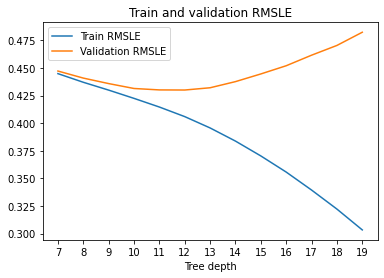

In [55]:

plt.plot(train_rmsle, label = 'Train RMSLE')
plt.plot(valid_rmlse, label = 'Validation RMSLE')
plt.title("Train and validation RMSLE")
plt.xlabel('Tree depth')
plt.xticks(range(0, 13) ,labels = range(7, 20))
plt.legend()
;

In [54]:
# The divergence of train and validation set metric happens at tree depth 11, thus we choose it as the best value.

print("Train rmsle", round(train_rmsle[4], 5))
print("Valid rmsle", round(valid_rmlse[4], 5))

Train rmsle 0.41
Valid rmsle 0.43


The metric has improved, but there is an opportunity to probably make it even better using ensemble methods.

## Regression: ensemble methods and prediction

In [56]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200,
                                max_depth = 12,
                                criterion = 'squared_error',
                                min_samples_split = 20,
                                random_state = 42)

rf.fit(X_train_scaled, y_train_log)

y_train_log_pred = rf.predict(X_train_scaled)
print("Train rmsle", round(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred)), 5))
y_pred = rf.predict(X_valid_scaled)
print("Valid rmsle", round(np.sqrt(mean_squared_error( y_valid_log, y_pred)), 5))

Train rmsle 0.4
Valid rmsle 0.41


In [57]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(learning_rate = 0.5,
                                n_estimators = 100,
                                max_depth = 6,
                                min_samples_split = 30,
                                random_state = 42, 
                                verbose= True)

gb.fit(X_train_scaled, y_train_log)


      Iter       Train Loss   Remaining Time 
         1           0.3110            9.99m
         2           0.2247            9.84m
         3           0.1987            9.72m
         4           0.1876            9.60m
         5           0.1823            9.50m
         6           0.1783            9.39m
         7           0.1756            9.31m
         8           0.1730            9.18m
         9           0.1709            9.05m
        10           0.1696            8.99m
        20           0.1577            7.90m
        30           0.1538            6.94m
        40           0.1502            5.99m
        50           0.1480            4.97m
        60           0.1451            3.99m
        70           0.1431            3.02m
        80           0.1410            2.03m
        90           0.1393            1.02m
       100           0.1383            0.00s
Train rmsle 0.37
Valid rmsle 0.39


In [63]:
y_train_log_pred = gb.predict(X_train_scaled)
print("Train rmsle", round(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred)), 5))
y_pred = gb.predict(X_valid_scaled)
print("Valid rmsle", round(np.sqrt(mean_squared_error( y_valid_log, y_pred)), 5))

Train rmsle 0.37184
Valid rmsle 0.39414


In [58]:
# XGBoost
import xgboost as xgb
# Create X in DMatrix format
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=selected_vars)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=selected_vars)

c:\Users\vi04wecu\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [59]:
# Hyperparameters
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Define train and validation samples
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Train
model = xgb.train(
    params=xgb_pars,
    dtrain=dtrain,
    num_boost_round=300, 
    evals=watchlist,
    early_stopping_rounds=20, 
    maximize=False,
    verbose_eval=10
)



[0]	train-rmse:5.42217	valid-rmse:5.42189
[10]	train-rmse:1.93578	valid-rmse:1.93572
[20]	train-rmse:0.78509	valid-rmse:0.78595
[30]	train-rmse:0.47870	valid-rmse:0.48079
[40]	train-rmse:0.42140	valid-rmse:0.42413
[50]	train-rmse:0.40968	valid-rmse:0.41286
[60]	train-rmse:0.40502	valid-rmse:0.40867
[70]	train-rmse:0.40169	valid-rmse:0.40563
[80]	train-rmse:0.39924	valid-rmse:0.40345
[90]	train-rmse:0.39784	valid-rmse:0.40234
[100]	train-rmse:0.39635	valid-rmse:0.40123
[110]	train-rmse:0.39510	valid-rmse:0.40032
[120]	train-rmse:0.39403	valid-rmse:0.39947
[130]	train-rmse:0.39286	valid-rmse:0.39864
[140]	train-rmse:0.39163	valid-rmse:0.39771
[150]	train-rmse:0.39067	valid-rmse:0.39713
[160]	train-rmse:0.39000	valid-rmse:0.39672
[170]	train-rmse:0.38911	valid-rmse:0.39611
[180]	train-rmse:0.38837	valid-rmse:0.39564
[190]	train-rmse:0.38772	valid-rmse:0.39534
[200]	train-rmse:0.38633	valid-rmse:0.39431
[210]	train-rmse:0.38554	valid-rmse:0.39390
[220]	train-rmse:0.38481	valid-rmse:0.39345

In [62]:
#print('Modeling RMSLE %.5f' %np.sqrt(model.best_score))
y_train_log_pred = model.predict(dtrain)
print("Train rmsle", round(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred)), 5))
y_pred = model.predict(dvalid)
print("Valid rmsle", round(np.sqrt(mean_squared_error( y_valid_log, y_pred)), 5))

Train rmsle 0.38026
Valid rmsle 0.39143


 XGBoost performs the best, thus, we will make predictions based on this model.

Now we explore what feature contribute the most to the prediction by plotting feature importance.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

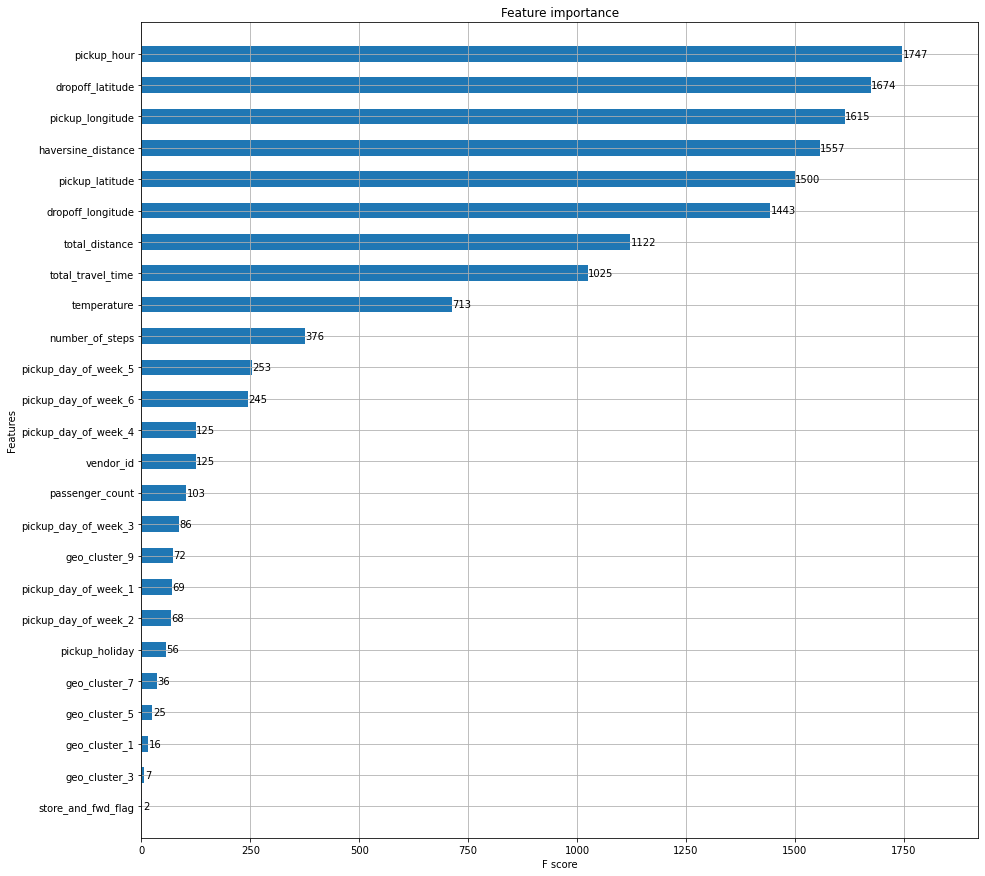

In [64]:
# Feature importance for the model solve with XGBoost.
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

Total distance, total pickup hour, dropoff latitude and pickup longitute are the strongest predictors. 

## Predictions

In [72]:
# upload test dataset
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id = test_data['id']

In [74]:
# Apply all the transformation to test data
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(holiday_data, test_data )
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data, coordinates)
test_data = add_cluster_features(test_data, coordinates_pickup, coordinates_dropoff)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data[osrm_vars] = test_data[osrm_vars].fillna(test_data[osrm_vars].median())
test_data['events'].fillna('None', inplace= True)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[selected_vars]
X_test_scaled = min_max.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [76]:
dtest = xgb.DMatrix(X_test_scaled, feature_names=selected_vars)

# Transform into non-logarithmic form
y_test_predict = np.exp(model.predict(dtest)) -1
# Create predictions and submission file
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_xgb.csv', index=False)